In [15]:
import scvelo as scv
from lets_plot import *
import polars as pl
import numpy as np
import cellestial as cl

LetsPlot.setup_html()

In [16]:
adata = scv.datasets.pancreas()

In [17]:
scv.pp.filter_genes(adata, min_shared_counts=20)
scv.pp.normalize_per_cell(adata)
scv.pp.filter_genes_dispersion(adata, n_top_genes=2000)
scv.pp.log1p(adata)
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 20801 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Filtered out 55 genes that are detected 20 counts (shared).
Skip filtering by dispersion since number of variables are less than `n_top_genes`.


/var/folders/wl/jrkngsm57b944tj7rtjg12000000gn/T/ipykernel_1601/2236818986.py:4: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  scv.pp.log1p(adata)
/Users/zaf4/Library/Caches/pypoetry/virtualenvs/cellestial-QESvkR8L-py3.12/lib/python3.12/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)
/var/folders/wl/jrkngsm57b944tj7rtjg12000000gn/T/ipykernel_1601/2236818986.py:6: DeprecationWarning: Automatic neighbor calculation is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors first with Scanpy.
  scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
/Users/zaf4/Library/Caches/pypoetry/virtualenvs/cellestial-QESvkR8L-py3.12/lib/python3.12/site-packages/scvelo/preprocessing/moments.py:

Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [18]:
scv.tl.velocity(adata)

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


/Users/zaf4/Library/Caches/pypoetry/virtualenvs/cellestial-QESvkR8L-py3.12/lib/python3.12/site-packages/scvelo/tools/optimization.py:184: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma[i] = np.linalg.pinv(A.T.dot(A)).dot(A.T.dot(y[:, i]))


In [19]:
scv.tl.velocity_graph(adata)

computing velocity graph (using 1/10 cores)
    finished (0:00:05) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [20]:
scv.tools.velocity_embedding(adata, basis="umap")

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


In [21]:
frame = (
    pl.from_numpy(adata.obsm["velocity_umap"], schema=["vel1", "vel2"])
    .with_columns(pl.from_numpy(adata.obsm["X_umap"], schema=["umap1", "umap2"]))
    .with_columns(pl.Series(adata.obs["clusters"]))
)

In [22]:
frame = frame.with_columns(
    pl.col("vel1").add(pl.col("umap1")).alias("xend"),
    pl.col("vel2").add(pl.col("umap2")).alias("yend"),
)
frame

vel1,vel2,umap1,umap2,clusters,xend,yend
f64,f64,f32,f32,cat,f64,f64
-0.021021,0.053618,6.143066,-0.063644,"""Pre-endocrine""",6.122045,-0.010025
-0.029884,-0.044597,-9.906417,0.197778,"""Ductal""",-9.936301,0.15318
0.003657,0.021857,7.559791,0.583762,"""Alpha""",7.563449,0.605619
-0.019717,0.051285,-11.283765,4.218998,"""Ductal""",-11.303482,4.270283
0.11154,0.004786,1.721565,-4.753407,"""Ngn3 high EP""",1.833104,-4.748622
…,…,…,…,…,…,…
0.049372,0.062256,4.768472,-1.388353,"""Pre-endocrine""",4.817844,-1.326097
0.08386,-0.012661,-1.873335,-4.18265,"""Ngn3 high EP""",-1.789475,-4.195312
-0.026134,-0.017431,-9.88225,-0.105594,"""Ductal""",-9.908384,-0.123025


In [23]:
base = (
    ggplot(frame)
    + geom_point(aes(x="umap1", y="umap2", color="clusters"), alpha=0.4)
    + scale_color_viridis(option="plasma")
    + ggsize(600, 400)
    + theme_void()
)
base

In [24]:
base + geom_curve(
    aes("umap1", "umap2", xend="xend", yend="yend"),
    curvature=0.5,
    size=0.5,
    color="black",
    arrow=arrow(angle=20),
    # sampling=sampling_random(1000),
    ncp=100,
)+ggsize(1200,800)

In [25]:
frame.schema

Schema([('vel1', Float64),
        ('vel2', Float64),
        ('umap1', Float32),
        ('umap2', Float32),
        ('clusters', Categorical(ordering='physical')),
        ('xend', Float64),
        ('yend', Float64)])

In [26]:
# Compute angles and magnitudes using NumPy
angles = np.arctan2(frame["vel2"].to_numpy(), frame["vel1"].to_numpy())
magnitudes = np.sqrt(frame["vel1"].to_numpy()**2 + frame["vel2"].to_numpy()**2)

# Add back to the DataFrame
frame = frame.with_columns(
    pl.Series("angle", angles),
    pl.Series("magnitude", magnitudes)
)

# Bin angles to group similar directions
angle_bin_size = np.pi / 2  # Adjust bin size as needed
frame = frame.with_columns(
    (pl.col("angle") / angle_bin_size).floor().alias("angle_bin")
)

# Group by spatial bins
spatial_bin_size = 1  # Adjust for better merging
frame = frame.with_columns(
    (pl.col("umap1") / spatial_bin_size).floor().alias("x_bin"),
    (pl.col("umap2") / spatial_bin_size).floor().alias("y_bin")
)

In [27]:
merged = (
    frame.group_by(["angle_bin", "x_bin", "y_bin"])
    .agg(
        pl.col("umap1").mean().alias("umap1"),  # Weighted centroid
        pl.col("umap2").mean().alias("umap2"),
        pl.col("vel1").sum().alias("vel1_sum"),  # Summing velocities instead of averaging
        pl.col("vel2").sum().alias("vel2_sum")
    )
    .with_columns(
        (pl.col("umap1") + pl.col("vel1_sum")).alias("xend"),  # Use integrated displacement
        (pl.col("umap2") + pl.col("vel2_sum")).alias("yend")
    )
)


In [28]:
merged

angle_bin,x_bin,y_bin,umap1,umap2,vel1_sum,vel2_sum,xend,yend
f64,f32,f32,f32,f32,f64,f64,f64,f64
-1.0,-11.0,-1.0,-10.699297,-0.577131,0.098546,-0.25474,-10.600751,-0.831871
-2.0,-12.0,2.0,-11.562881,2.541834,-0.169756,-0.127708,-11.732637,2.414126
1.0,-11.0,-1.0,-10.838547,-0.940426,-0.015847,0.006424,-10.854394,-0.934002
-1.0,-3.0,-4.0,-2.537255,-3.749838,2.500413,-0.429373,-0.036842,-4.179211
-1.0,2.0,1.0,2.307015,1.374167,0.006822,-0.005052,2.313837,1.369115
…,…,…,…,…,…,…,…,…
1.0,5.0,-3.0,5.57636,-2.090811,-0.005752,0.068562,5.570608,-2.02225
-1.0,1.0,-4.0,1.562536,-3.471871,0.194054,-0.008504,1.756591,-3.480375
1.0,5.0,1.0,5.427372,1.518916,-1.21533,2.496624,4.212041,4.01554


In [29]:

base + geom_curve(
    data=merged,
    mapping=aes("umap1", "umap2", xend="xend", yend="yend"),
    curvature=0,
    size=0.5,
    color="black",
    arrow=arrow(angle=10, type="closed"),
    sampling=sampling_random(1000),
    ncp=10
)


/Users/zaf4/Library/Caches/pypoetry/virtualenvs/cellestial-QESvkR8L-py3.12/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/zaf4/Library/Caches/pypoetry/virtualenvs/cellestial-QESvkR8L-py3.12/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/zaf4/Library/Caches/pypoetry/virtualenvs/cellestial-QESvkR8L-py3.12/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isi

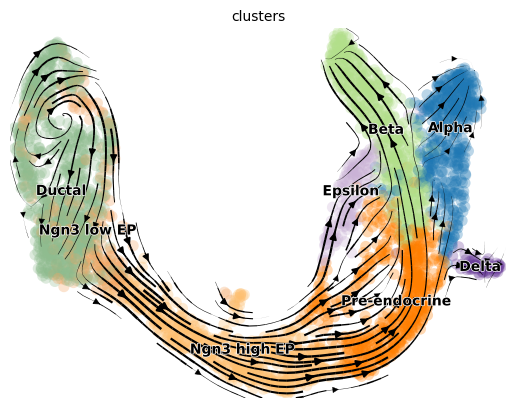

In [30]:
scv.pl.velocity_embedding_stream(adata)

In [31]:
adata

AnnData object with n_obs × n_vars = 3696 × 1945
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition'
    var: 'highly_variable_genes', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca', 'log1p', 'velocity_params', 'velocity_graph', 'velocity_graph_neg'
    obsm: 'X_pca', 'X_umap', 'velocity_umap'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu', 'velocity', 'variance_velocity'
    obsp: 'distances', 'connectivities'

In [35]:
cl.umap(adata,key="clusters", size=1,legend_ondata=True,ondata_size=8,axis_type="arrow")